In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import tensorflow as tf

In [2]:
# default initial values of DOE factors:
# learning_rate = 0.001
# dropout_value = 0.3
# #n-conv_layers = 3
# n_units_last_layer = 2048
# n_filters_l1 = 32
# n_filters_l2 = 16

In [3]:
# DOE factors:
learning_rate = 0.001
dropout_value = 0.3
# n-conv_layers = 3
n_units_last_layer = 2048
n_filters_l1 = 4
n_filters_l2 = 32

In [4]:
# other factors:
img_size = 130
batch_size = 32
validation_split = 0.1  # 10% for validation
test_split = 0.00  # 0% for testing
shuffle_buffer_size = 1000
seed_num = 101
desired_accuracy = 0.99  # it should be active if EarlyStoppingCallback is activated
loss = 'binary_crossentropy'
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
metrics = ['accuracy']
epochs = 15
f_mode = 'nearest'  # fill_mode in image augmentation

    My dataset_root/
    ├── woman/
    │   ├── woman_1.jpg
    │   ├── woman_2.jpg
    │   ├── ...
    ├── man/
    │   ├── man_1.jpg
    │   ├── man_2.jpg
    │   ├── ...

In [6]:
import os

DATA_DIR = "D:\\CS online courses\\Free DataSets\\Free Images\\Easier portrait images_GPU_03"

# Subdirectories for each class
data_dir_woman = os.path.join(DATA_DIR, 'woman')
data_dir_man = os.path.join(DATA_DIR, 'man')

# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(data_dir_woman))} images of woman.")
print(f"There are {len(os.listdir(data_dir_man))} images of man.")

There are 471 images of woman.
There are 472 images of man.


In [7]:
image_size = (img_size, img_size)  # Resize images to this size

# Load train dataset (excluding validation & test set):
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = DATA_DIR,
    image_size = image_size,
    batch_size = batch_size,
    label_mode='binary',
    validation_split = validation_split + test_split,  # Total split for val + test
    subset = "training",
    seed = seed_num
)

# Load validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = DATA_DIR,
    image_size = image_size,
    batch_size = batch_size,
    label_mode='binary',
    validation_split = validation_split + test_split,
    subset = "validation",
    seed = seed_num
)

# Further manually split validation dataset to extract test dataset
val_batches = tf.data.experimental.cardinality(val_dataset)
# Compute test dataset size (number of batches)
test_size = round(val_batches.numpy() * (test_split / (validation_split + test_split)))
# Split validation dataset into validation and test subsets
test_dataset = val_dataset.take(test_size)
val_dataset = val_dataset.skip(test_size)


print(f"Train batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_dataset).numpy()}")

# Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = train_dataset.cache().shuffle(shuffle_buffer_size).prefetch(buffer_size = AUTOTUNE)
validation_dataset = val_dataset.cache().prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size = AUTOTUNE)

Found 943 files belonging to 2 classes.
Using 849 files for training.
Found 943 files belonging to 2 classes.
Using 94 files for validation.
Train batches: 27
Validation batches: 3
Test batches: 0


In [8]:
# Get the first batch of images and labels
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

max_pixel = np.max(example_batch_images)
print(f"Maximum pixel value of images: {max_pixel}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (32, 130, 130, 3)
Shape of batch of labels: (32, 1)


In [9]:
'''
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if train_accuracy >= desired_accuracy and val_accuracy >= desired_accuracy:
            self.model.stop_training = True
            print(f"\nReached {desired_accuracy}% accuracy so cancelling training!")
'''

'\nclass EarlyStoppingCallback(tf.keras.callbacks.Callback):\n    def on_epoch_end(self, epoch, logs=None):\n        train_accuracy = logs.get(\'accuracy\')\n        val_accuracy = logs.get(\'val_accuracy\')\n        if train_accuracy >= desired_accuracy and val_accuracy >= desired_accuracy:\n            self.model.stop_training = True\n            print(f"\nReached {desired_accuracy}% accuracy so cancelling training!")\n'

In [10]:
'''
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)
'''

"\nfrom tensorflow.keras.callbacks import EarlyStopping\nearly_stop = EarlyStopping(monitor='val_loss', patience=3)\n"

In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Reduce LR every 10 epochs (Learning rate decay factor)
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 1.0
    return lr

lr_callback = LearningRateScheduler(scheduler)

In [12]:
# augmentation_model
def augment_model():
    """Creates a model (layers stacked on top of each other) for augmenting images of woman and man.

    Returns:
        tf.keras.Model: The model made up of the layers that will be used to augment the images of woman and man.
    """

    augmentation_model = tf.keras.Sequential([
        # Specify the input shape.
        tf.keras.Input(shape = (img_size, img_size, 3)),
        
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1, fill_mode = f_mode),
        #tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode = f_mode),
        #tf.keras.layers.RandomZoom(0.1, fill_mode=f_mode)
        ])

    return augmentation_model

In [13]:
def create_and_compile_model():
    """Creates, compiles and trains the model to predict woman and man images.

    Returns:
        tf.keras.Model: The model that will be trained to predict woman and man images.
    """

    augmentation_layers = augment_model()
    
    model = tf.keras.Sequential([
        # Note: the input shape is the desired size of the image: 150x150 with 3 bytes for color
        tf.keras.layers.InputLayer(shape = (img_size, img_size, 3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),
        #####    CONV_LAYER_1:     #####
        tf.keras.layers.Conv2D(n_filters_l1, (4, 4), activation = 'linear'),
        tf.keras.layers.MaxPooling2D(2, 2),
        #####    CONV_LAYER_2:     #####
        tf.keras.layers.Conv2D(n_filters_l2, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        #####    CONV_LAYER_3:     #####
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(dropout_value),
        #####    BEFORE_LAST_LAYER:     #####
        tf.keras.layers.Dense(n_units_last_layer, activation = 'relu'),
        # It will contain a value from 0-1 where 0 for the class 'female' and 1 for the 'male'
        tf.keras.layers.Dense(1, activation = 'sigmoid')]) 

    model.compile(
        loss = loss,
        optimizer = optimizer,
        metrics = metrics
    )

    return model

In [14]:
# Create the compiled but untrained model
model = create_and_compile_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 130, 130, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 130, 130, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 127, 127, 4)    │           196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    25,692,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,714,085 (98.09 MB)

 Trainable params: 25,714,085 (98.09 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
'''
training_history = model.fit(
    training_dataset,
    epochs = epochs,
    validation_data = validation_dataset,
    callbacks = [EarlyStoppingCallback()],
    verbose = 2
)
'''

'\ntraining_history = model.fit(\n    training_dataset,\n    epochs = epochs,\n    validation_data = validation_dataset,\n    callbacks = [EarlyStoppingCallback()],\n    verbose = 2\n)\n'

In [16]:
'''
training_history = model.fit(
    training_dataset,
    epochs = epochs,
    validation_data = validation_dataset,
    callbacks=[early_stop],
    verbose = 2
)
'''

'\ntraining_history = model.fit(\n    training_dataset,\n    epochs = epochs,\n    validation_data = validation_dataset,\n    callbacks=[early_stop],\n    verbose = 2\n)\n'

In [17]:
training_history = model.fit(
    training_dataset,
    epochs = epochs,
    validation_data = validation_dataset,
    callbacks = [lr_callback],
    verbose = 2
)

Epoch 1/15
27/27 - 5s - 185ms/step - accuracy: 0.6031 - loss: 0.7868 - val_accuracy: 0.6489 - val_loss: 0.6188 - learning_rate: 0.0010
Epoch 2/15
27/27 - 3s - 124ms/step - accuracy: 0.7197 - loss: 0.5643 - val_accuracy: 0.6702 - val_loss: 0.5615 - learning_rate: 0.0010
Epoch 3/15
27/27 - 3s - 115ms/step - accuracy: 0.7409 - loss: 0.5243 - val_accuracy: 0.7872 - val_loss: 0.5181 - learning_rate: 0.0010
Epoch 4/15
27/27 - 3s - 109ms/step - accuracy: 0.7903 - loss: 0.4539 - val_accuracy: 0.7553 - val_loss: 0.5188 - learning_rate: 0.0010
Epoch 5/15
27/27 - 3s - 108ms/step - accuracy: 0.8057 - loss: 0.4501 - val_accuracy: 0.8085 - val_loss: 0.4298 - learning_rate: 0.0010
Epoch 6/15
27/27 - 3s - 111ms/step - accuracy: 0.7868 - loss: 0.4656 - val_accuracy: 0.8191 - val_loss: 0.5162 - learning_rate: 0.0010
Epoch 7/15
27/27 - 3s - 110ms/step - accuracy: 0.8210 - loss: 0.4036 - val_accuracy: 0.8085 - val_loss: 0.4043 - learning_rate: 0.0010
Epoch 8/15
27/27 - 3s - 106ms/step - accuracy: 0.8221 -

In [18]:
#from tensorflow.keras.models import load_model
#model.save('gender_recognition_project04_v10.h5')

In [19]:
model.metrics_names

['loss', 'compile_metrics']

In [20]:
result_history = pd.DataFrame(model.history.history)
result_history.head(15)

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.603062,0.786806,0.648936,0.618785,0.001
1,0.719670,0.564318,0.670213,0.561484,0.001
2,0.740872,0.524252,0.787234,0.518064,0.001
3,0.790342,0.453903,0.755319,0.518814,0.001
4,0.805654,0.450082,0.808511,0.429755,0.001
5,0.786808,0.465649,0.819149,0.516206,0.001
6,0.820966,0.403576,0.808511,0.404284,0.001
7,0.822144,0.389590,0.787234,0.406701,0.001
8,0.838634,0.357589,0.829787,0.398780,0.001
9,0.838634,0.345951,0.808511,0.464991,0.001


<Axes: >

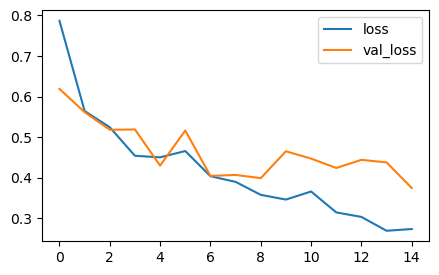

In [21]:
result_history[['loss', 'val_loss']].plot(figsize=(5, 3))

<Axes: >

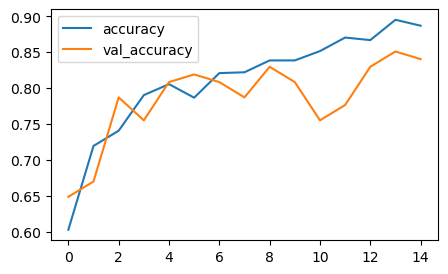

In [22]:
result_history[['accuracy', 'val_accuracy']].plot(figsize=(5, 3))

In [23]:
print(model.metrics_names)
print(model.evaluate(validation_dataset))

['loss', 'compile_metrics']
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8226 - loss: 0.3964
[0.3744068443775177, 0.8404255509376526]


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.concatenate([y.numpy() for _, y in validation_dataset])
y_pred_prob = model.predict(validation_dataset)
# Convert probabilities to class labels (0:Female or 1:Male)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Female', 'Male']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Classification Report:
               precision    recall  f1-score   support

      Female       0.80      0.85      0.82        41
        Male       0.88      0.83      0.85        53

    accuracy                           0.84        94
   macro avg       0.84      0.84      0.84        94
weighted avg       0.84      0.84      0.84        94



In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array

img_size = img_size
model = tf.keras.models.load_model("gender_recognition_project04_v10.h5")

# Load your personal image if you are interested to predict:
your_image_path = "D:\\Hossein's desktop files in Microsoft Studio Laptop\\Personal Photos\\Hossein_10.jpg"

img = load_img(your_image_path, target_size=(img_size, img_size))
final_img = img_to_array(img)
# Adding a batch dimension:
final_img = np.expand_dims(final_img, axis=0)
prediction = model.predict(final_img)
result = "Female" if prediction > 0.5 else "Male"
if result=="Female":
    confidence = (model.predict(final_img)[0][0])*100
else:
    confidence = (1-model.predict(final_img)[0][0])*100
print(f"Prediction result: {result} (confidence= {confidence:.2f} %)")

# Visualize CNN Layers
successive_feature_maps = visualization_model.predict(final_img)
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:  # Only visualize conv/maxpool layers
        n_features = feature_map.shape[-1]  # Number of filters
        size = feature_map.shape[1]  # Feature map size
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= (x.std() + 1e-8)  # Normalize
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')  # Convert to image format
            display_grid[:, i * size: (i + 1) * size] = x

        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='cividis')
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction result: Male (confidence= 94.19 %)


NameError: name 'visualization_model' is not defined